<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%84%9C%EC%9A%B8%EB%9E%9C%EB%93%9C%EB%A7%88%ED%81%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서울 랜드마크 이미지 분류 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import cv2
import os
import gc

from tqdm.notebook import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data


In [4]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data/dataset.zip'

In [5]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류


- 데이터 불러오기

In [6]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

- 하이퍼파라미터

In [7]:
SAVE_PATH = './weight'
MODEL_NAME = 'convmixer'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_NAME}_default_weight.pt' 
NUM_CLASSES = 10
N_FOLD = 5
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 6e-4
LABEL_SMOOTHING = 0.05  ## 적절한 값을 설정하여 모델이 예측한 것을 과하게 확신하지 못하게 함
IMAGE_H = 240
IMAGE_W = 240
SEED = 2022

- 가중치 저장폴더

In [8]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [9]:
create_folder(SAVE_PATH)

- 이미지 불러오기

In [59]:
def load_images(path):
    images = []
    for img_path in tqdm(sorted(glob(path + '/*.PNG'))): ## path에 들어있는 PNG 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = cv2.imread(img_path)  
        an_img = cv2.cvtColor(an_img, cv2.COLOR_BGR2RGB)
        an_img = cv2.resize(an_img, dsize=(IMAGE_W, IMAGE_H), interpolation=cv2.INTER_LINEAR) 
        images.append(an_img)  
    
    images = np.array(images).astype(np.float32)
    return images

In [60]:
train_images = load_images(path='./Data/train')
test_images = load_images(path='./Data/test')

  0%|          | 0/723 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

In [12]:
train_images.shape, test_images.shape

((723, 240, 240, 3), (199, 240, 240, 3))

## 시각화

- 이미지

In [13]:
def show_images(images, labels, nrows=3, ncols=3) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*2, ncols*2))
    nums = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))
    
    for i, ax in enumerate(axs.flatten()):
        num = nums[i]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[num])
        ax.imshow(images[num])
    fig.tight_layout()

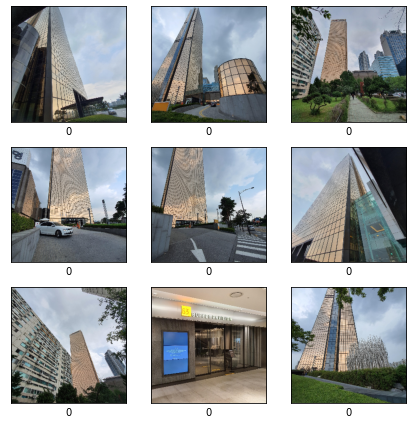

In [14]:
show_images(train_images[df.query('label == 0').index].astype(np.uint8), [0]*1000)

`-` 클래스 0은 외부에서 찍은 사진과 내부에서 찍은 사진으로 나뉜다

`-` 외부에서 찍은 사진은 비교적 일관적이지만 내부에서 찍은 사진은 제각각이다

`-` 적절한 라벨스무딩이 필요할 듯 하다

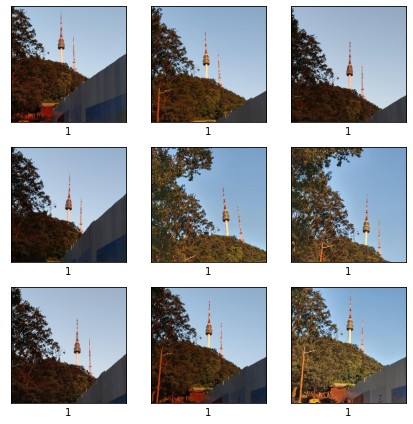

In [15]:
show_images(train_images[df.query('label == 1').index].astype(np.uint8), [1]*1000) 

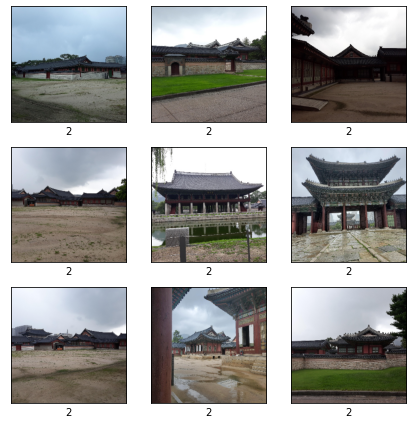

In [16]:
show_images(train_images[df.query('label == 2').index].astype(np.uint8), [2]*1000)

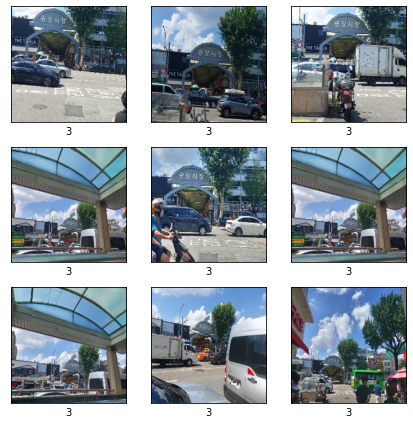

In [17]:
show_images(train_images[df.query('label == 3').index].astype(np.uint8), [3]*1000)

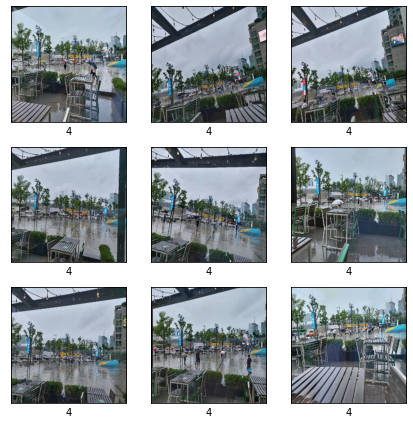

In [18]:
show_images(train_images[df.query('label == 4').index].astype(np.uint8), [4]*1000)

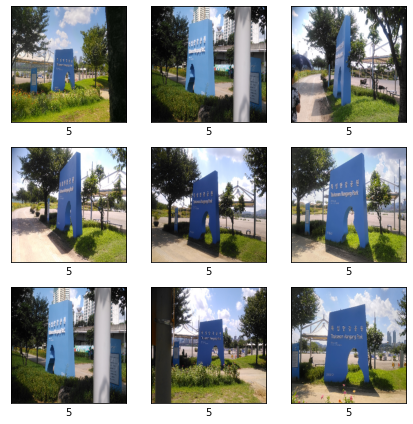

In [19]:
show_images(train_images[df.query('label == 5').index].astype(np.uint8), [5]*1000)

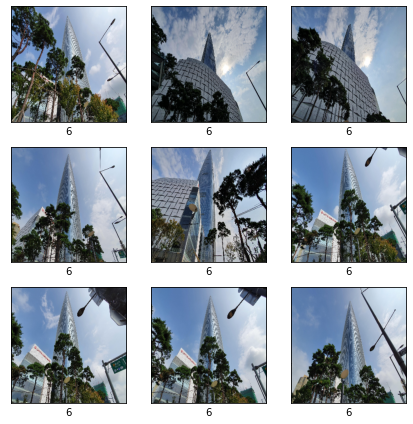

In [20]:
show_images(train_images[df.query('label == 6').index].astype(np.uint8), [6]*1000)

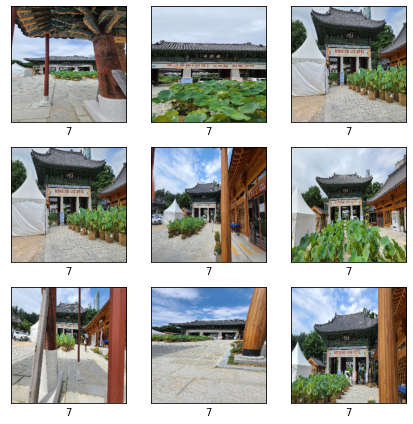

In [21]:
show_images(train_images[df.query('label == 7').index].astype(np.uint8), [7]*1000)

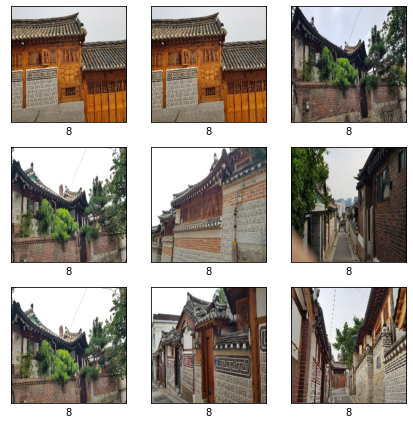

In [22]:
show_images(train_images[df.query('label == 8').index].astype(np.uint8), [8]*1000)

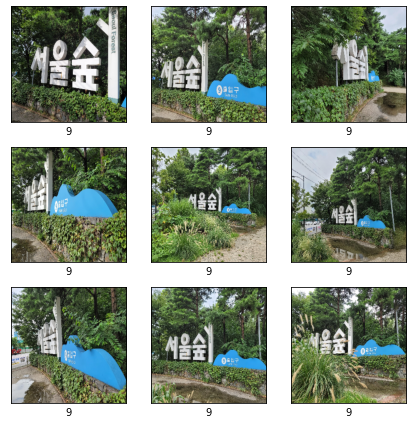

In [23]:
show_images(train_images[df.query('label == 9').index].astype(np.uint8), [9]*1000)

- 라벨

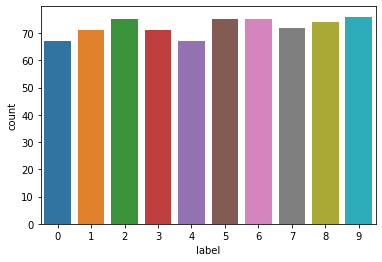

In [24]:
sns.countplot(data=df, x='label')

`-` 라벨별 개수는 비슷하다

## 모델 학습 준비

In [25]:
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [28]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [29]:
def seed_everything(seed=22):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [30]:
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

- 데이터 셋과 데이터 로더

In [31]:
class CustomDataset(Dataset):
  
    def __init__(self, images, labels=None, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images)  

In [32]:
def get_dataloader(X, y=None, transforms=None, shuffle_dataloader=True):
    dataset = CustomDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 데이터 변환

In [33]:
RGB_MEAN = [np.mean((train_images[..., i])) / 255 for i in range(3)] 
RGB_STD = [np.std(train_images[..., i]) / 255 for i in range(3)]  

In [80]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(train_mode=True):
    transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
        ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환 
    ])
    
    if train_mode:
        transforms = A.Compose([
            A.CenterCrop(224, 224),   
            A.Perspective(scale=0.2, p=0.5),
            A.Rotate(limit=25, p=0.5),  
            A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
            ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환  
        ])

    return transforms  ## 데이터 변환 방식을 반환

`-` 색을 바꾸면 클래스 0과 6을 구분하기 힘들다

`-` 그래서 색을 변형시키는 변환은 사용하지 않겠다

In [35]:
target = df['label'].values

- 딥러닝 모델

In [36]:
## Copyright (c) 2021 Author(s) of ICLR 2022 Submission "Patches Are All You Need?"
## 코드: https://github.com/locuslab/convmixer/blob/main/convmixer.py
class Residual(nn.Module):
  
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=3, patch_size=3, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding='same'),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

- 가중치 초기화

In [37]:
## layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        nn.init.normal_(m.weight.data, 0.0, np.sqrt(2 / y))
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

- 조기 중단

In [38]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', model_name='', current_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7

            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
                            
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0
        self.delta = delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(self, model, val_loss, val_acc):
        score = -val_loss  ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            if self.counter >= self.patience:  ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, val_acc, model) 
            self.counter = 0  ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.current_fold}.pt') 
        self.val_loss_min = val_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc  ## 이때의 valid accuracy도 변경해준다

    def set_fold(self, current_fold):
        self.current_fold = current_fold

    def reset_score(self):
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0

## 모델 K겹 교차검증

In [39]:
from sklearn.model_selection import StratifiedKFold

- Kfold와 손실 함수

In [40]:
skfold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

- early stopping

In [41]:
early_stopping = EarlyStopping(patience=20,
                               verbose=False,
                               path=SAVE_PATH,
                               model_name=MODEL_NAME,
                               n_fold=1)  ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단

- 모델 교차검증 관련 함수

In [42]:
def train(model, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 에폭 하나당 배치들의 평균 훈련 오차를 반환"""  
    train_avg_loss = 0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()

    for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        yhat = model(X)
        loss = loss_fn(yhat, y)  
        optimizer.zero_grad()  ## 그래디언트 초기화
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_avg_loss += (loss.item() / len(dataloader)) 
  
    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [43]:
def evaluate(model, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 에폭 하나당 배치들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y)  
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader)    

    return valid_avg_loss, valid_avg_acc

In [44]:
def show_loss_plot(train_loss, valid_loss, ax) -> None:
    assert len(train_loss) == len(valid_loss)
    
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [81]:
def kfold_cross_validate(model, X, y, skfold, loss_fn, early_stopping):
    seed_everything(SEED)  ## 정확한 loss 재현을 위함
    model_avg_acc = []  ## fold 마다 valid셋의 평균 정확도
    model_avg_loss = []  ## fold 마다 valid셋의 평균 손실
    model_epoch_train_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 train의 한 epoch당 valid의 배치 평균 손실
    model_epoch_valid_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 valid의 한 epoch당 valid의 배치 평균 손실

    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{fold + 1} / {N_FOLD}] Fold Training......')

        ## 메모리 절약
        clear_gpu()
        
        ## 학습 데이터와 평가 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]
        y_train = torch.tensor(y_train, dtype=torch.int64)   
        y_valid = torch.tensor(y_valid, dtype=torch.int64)   

        ## Dataloader
        train_dataloader = get_dataloader(X_train, y_train, get_transforms(train_mode=True))
        valid_dataloader = get_dataloader(X_valid, y_valid, get_transforms(train_mode=False))

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device)) 

        ## optimizer, scheduler
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) 
        scheduler = None

        ## early stop, 다음 fold 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_fold(fold + 1)  
        
        ## fold 마다 모델 학습
        for epoch in tqdm(range(1, EPOCHS + 1)): ## (배치사이즈 * 에폭) 만큼 훈련시킴           
            model, train_avg_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_avg_loss, valid_avg_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            model_epoch_train_loss[fold].append(train_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
            model_epoch_valid_loss[fold].append(valid_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == EPOCHS)  ## 10의 배수값을 가지는 에폭마다 score 출력
            score_infomation = f'[Epoch: {epoch:>3}] train loss = {train_avg_loss:>.5f}  valid loss = {valid_avg_loss:>.5f}  valid acc = {valid_avg_acc:>.5f}'

            if print_score_condition: 
                ## 평균 배치 훈련 오차와 평가 오차 출력
                print(score_infomation) 
                
            ## epoch 마다 early stopping 실행
            early_stopping(model, valid_avg_loss, valid_avg_acc)  ## __call__ function
            if early_stopping.early_stop:  ## early_stop이 true이면
                if not print_score_condition:
                    ## 이미 출력한 epoch에 대해 중복으로 출력하지 않기 위함
                    print(score_infomation) 
                print('Early Stopping!')
                break 

        model_avg_acc.append(early_stopping.val_acc)  ## fold 마다 loss가 가장 작은 모델의 정확도
        model_avg_loss.append(early_stopping.val_loss_min)  ## fold 마다 loss가 가장 작은 모델의 손실
        
        ## fold 마다 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.5f}  Valid Accuracy: {early_stopping.val_acc:.5f}', end='\n\n')
        
    ## 마지막으로 fold 마다 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
    print(f'{N_FOLD} Fold Mean Valid Accuracy: {np.mean(model_avg_acc):.5f}')
    print(f'{N_FOLD} Fold Mean Valid Loss: {np.mean(model_avg_loss):.5f}')

    return model, model_epoch_train_loss, model_epoch_valid_loss, model_avg_acc, model_avg_loss

- 모델 선언 및 초기화시킨 가중치 저장

In [46]:
seed_everything(SEED)
model = ConvMixer(dim=2**7, depth=8, kernel_size=7, patch_size=7, n_classes=NUM_CLASSES)
model.apply(init_weights)
torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH) 

- 모델 K겹 교차검증

In [82]:
model, model_epoch_train_loss, model_epoch_valid_loss, _, _ = kfold_cross_validate(model, train_images, target, skfold, loss_fn, early_stopping)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.29980  valid loss = 0.98076  valid acc = 0.67586
[Epoch:  10] train loss = 0.42882  valid loss = 0.52501  valid acc = 0.95172
[Epoch:  20] train loss = 0.36989  valid loss = 0.38673  valid acc = 0.97931
[Epoch:  30] train loss = 0.38398  valid loss = 0.36797  valid acc = 0.99310
[Epoch:  40] train loss = 0.35380  valid loss = 0.37514  valid acc = 0.97931
[Epoch:  50] train loss = 0.34918  valid loss = 0.36928  valid acc = 0.97931
[Epoch:  60] train loss = 0.39478  valid loss = 0.34983  valid acc = 0.98621
[Epoch:  70] train loss = 0.34628  valid loss = 0.37973  valid acc = 0.98621
[Epoch:  80] train loss = 0.32983  valid loss = 0.33012  valid acc = 1.00000
[Epoch:  81] train loss = 0.33592  valid loss = 0.35368  valid acc = 0.97931
Early Stopping!
1 Fold -> Best Valid Loss: 0.32850  Valid Accuracy: 1.00000

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.30089  valid loss = 1.12619  valid acc = 0.64138
[Epoch:  10] train loss = 0.41507  valid loss = 0.40760  valid acc = 0.97931
[Epoch:  20] train loss = 0.40384  valid loss = 0.55169  valid acc = 0.94483
[Epoch:  30] train loss = 0.38951  valid loss = 0.36006  valid acc = 0.99310
[Epoch:  40] train loss = 0.35670  valid loss = 0.36031  valid acc = 0.99310
[Epoch:  50] train loss = 0.34690  valid loss = 0.35182  valid acc = 0.98621
[Epoch:  60] train loss = 0.34992  valid loss = 0.35299  valid acc = 0.98621
[Epoch:  63] train loss = 0.33907  valid loss = 0.37200  valid acc = 0.97931
Early Stopping!
2 Fold -> Best Valid Loss: 0.34061  Valid Accuracy: 0.99310

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.25818  valid loss = 1.12967  valid acc = 0.68276
[Epoch:  10] train loss = 0.42949  valid loss = 0.44888  valid acc = 0.95862
[Epoch:  20] train loss = 0.44110  valid loss = 0.42547  valid acc = 0.95862
[Epoch:  30] train loss = 0.38815  valid loss = 0.41045  valid acc = 0.95862
[Epoch:  40] train loss = 0.35976  valid loss = 0.36723  valid acc = 0.97931
[Epoch:  50] train loss = 0.39770  valid loss = 0.36181  valid acc = 0.98621
[Epoch:  60] train loss = 0.35591  valid loss = 0.35188  valid acc = 0.99310
[Epoch:  70] train loss = 0.36079  valid loss = 0.35647  valid acc = 0.98621
[Epoch:  74] train loss = 0.34150  valid loss = 0.34894  valid acc = 0.98621
Early Stopping!
3 Fold -> Best Valid Loss: 0.33851  Valid Accuracy: 0.98621

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.28604  valid loss = 1.20999  valid acc = 0.59028
[Epoch:  10] train loss = 0.39860  valid loss = 0.42819  valid acc = 0.97222
[Epoch:  20] train loss = 0.41053  valid loss = 0.48707  valid acc = 0.95139
[Epoch:  30] train loss = 0.35385  valid loss = 0.36798  valid acc = 0.98611
[Epoch:  40] train loss = 0.34873  valid loss = 0.39568  valid acc = 0.97222
[Epoch:  50] train loss = 0.32406  valid loss = 0.36795  valid acc = 0.97917
[Epoch:  53] train loss = 0.31555  valid loss = 0.39000  valid acc = 0.97222
Early Stopping!
4 Fold -> Best Valid Loss: 0.35969  Valid Accuracy: 0.97917

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.30543  valid loss = 1.19969  valid acc = 0.64583
[Epoch:  10] train loss = 0.42573  valid loss = 0.39355  valid acc = 0.98611
[Epoch:  20] train loss = 0.37969  valid loss = 0.36084  valid acc = 0.99306
[Epoch:  30] train loss = 0.37613  valid loss = 0.42993  valid acc = 0.98611
[Epoch:  40] train loss = 0.34586  valid loss = 0.34012  valid acc = 0.99306
[Epoch:  47] train loss = 0.33074  valid loss = 0.34422  valid acc = 0.99306
Early Stopping!
5 Fold -> Best Valid Loss: 0.32996  Valid Accuracy: 0.99306

5 Fold Mean Valid Accuracy: 0.99031
5 Fold Mean Valid Loss: 0.33945


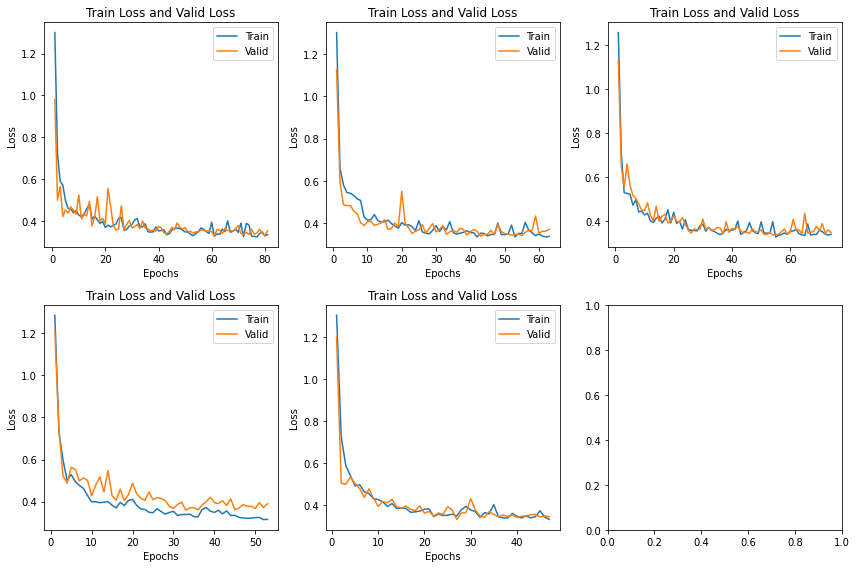

In [83]:
## 폴드마다 에폭에 따른 train loss와 valid loss의 변화를 시각화
fig ,axs = plt.subplots(2, 3, figsize=(12, 8)) 
for i, ax in enumerate(axs.flatten()):
    try:
        show_loss_plot(model_epoch_train_loss[i], model_epoch_valid_loss[i], ax)
    except:
        pass
fig.tight_layout()

## Test 예측

In [64]:
def predict(model, dataloader, weight_save_path, return_prob=False):
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환 """
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight in tqdm(weight_path_list):
        if MODEL_NAME not in weight:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue
            
        probs = None
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        
        with torch.no_grad(): 
            for X in dataloader:  ## test 데이터는 라벨(y)이 없다
                X = X.to(device)
                yhat = model(X).cpu().numpy()

                if probs is None:
                    probs = yhat
                else:
                    probs = np.concatenate([probs, yhat])

        test_probs += (probs / N_FOLD) 
    test_probs = torch.softmax(torch.tensor(test_probs), dim=1)  ## 각 컬럼별 확률값
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1)  ## 최대값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률값
    return test_preds  ## 라벨값

In [84]:
test_dataloader = get_dataloader(X=test_images, y=None, transforms=get_transforms(train_mode=False), shuffle_dataloader=False)

In [87]:
test_preds = predict(model, test_dataloader, SAVE_PATH, return_prob=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [88]:
submission['label'] = test_preds
submission.head()

,file_name,label
0,001.PNG,7
1,002.PNG,1
2,003.PNG,9
3,004.PNG,7
4,005.PNG,6


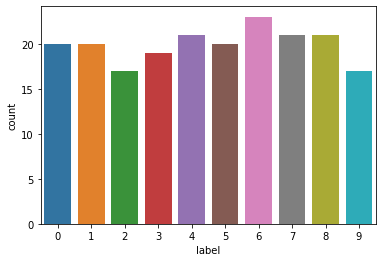

In [89]:
sns.countplot(data=submission, x='label')

In [90]:
# submission.to_csv(f'./Data/submission-{MODEL_NAME}9.csv', index=False)